In [1]:
import torch
torch.cuda.set_device('cuda:0')

import logging
logging.disable(logging.CRITICAL) # comment out to enable verbose logging

#########################################################

import os
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from PIL import Image
from collections import defaultdict
from pathlib import Path
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T
from tqdm import tqdm
from types import SimpleNamespace
from detectron2.checkpoint import DetectionCheckpointer


import config
import utils as ut
from eval_utils import MaskMerger
from mask_former_trainer import setup, Trainer


def load_model_cfg(ckpt_path, dataset=None):
    experiment = Path('../outputs/') / ckpt_path

    # args = SimpleNamespace(config_file=str(experiment / 'config.yaml'), opts=[], wandb_sweep_mode=False, resume_path=str(experiment / 'checkpoints/checkpoint_best.pth'), eval_only=True) # better way
    args = SimpleNamespace(config_file='configs/maskformer/maskformer_R50_bs16_160k_dino.yaml', opts=["GWM.DATASET", dataset], wandb_sweep_mode=False, resume_path=str(experiment / 'checkpoints/checkpoint_best.pth'), eval_only=True)
    cfg = setup(args)
    random_state = ut.random_state.PytorchRNGState(seed=cfg.SEED).to(torch.device(cfg.MODEL.DEVICE))

    model = Trainer.build_model(cfg)
    checkpointer = DetectionCheckpointer(model,
                                         random_state=random_state,
                                         save_dir=os.path.join(cfg.OUTPUT_DIR, '../..', 'checkpoints'))

    checkpoint_path = str(experiment / 'checkpoints/checkpoint_best.pth')
    checkpoint = checkpointer.resume_or_load(checkpoint_path, resume=False)
    model.eval()

    return model, cfg

In [2]:
# from https://github.com/lukemelas/unsupervised-image-segmentation/
@torch.no_grad()
def compute_metrics(preds, targets, metrics=['f_max', 'acc', 'iou'], threshold=0.5, swap_dims=False):

    # Move to CPU
    preds = preds.detach()  # .cpu()
    targets = targets.detach()  # .cpu()
    assert len(preds.shape) == 4 and len(targets.shape) == 3
    soft_preds = torch.softmax(preds, dim=1)[:, (0 if swap_dims else 1)]  # convert to probabilities
    hard_preds = soft_preds > threshold

    # Compute
    results = defaultdict(list)
    for soft_pred, hard_pred, target in zip(soft_preds, hard_preds, targets):
        if 'f_max' in metrics:
            precision, recall = compute_prs(soft_pred, target, prob_bins=255)
            results['f_max_precision'].append(precision)
            results['f_max_recall'].append(recall)
        if 'f_beta' in metrics:
            precision, recall = precision_recall(target, hard_preds)
            results['f_beta_precision'].append([precision])
            results['f_beta_recall'].append([recall])
        if 'acc' in metrics:
            acc = compute_accuracy(hard_pred, target)
            results['acc'].append(acc)
        if 'iou' in metrics:
            iou = compute_iou(hard_pred, target)
            results['iou'].append(iou)
    return results


@torch.no_grad()
def aggregate_metrics(totals):
    results = defaultdict(list)
    if 'acc' in totals:
        results['acc'] = mean(totals['acc'])
    if 'iou' in totals:
        results['iou'] = mean(totals['iou'])
    if 'loss' in totals:
        results['loss'] = mean(totals['loss'])
    if 'f_max_precision' in totals and 'f_max_recall' in totals:
        precisions = torch.tensor(totals['f_max_precision'])
        recalls = torch.tensor(totals['f_max_recall'])
        results['f_max'] = F_max(precisions, recalls)
    if 'f_beta_precision' in totals and 'f_beta_recall' in totals:
        precisions = torch.tensor(totals['f_beta_precision'])
        recalls = torch.tensor(totals['f_beta_recall'])
        results['f_beta'] = F_max(precisions, recalls)
    return results


def compute_accuracy(pred, target):
    pred, target = pred.to(torch.bool), target.to(torch.bool)
    return torch.mean((pred == target).to(torch.float)).item()


def compute_iou(pred, target):
    pred, target = pred.to(torch.bool), target.to(torch.bool)
    intersection = torch.sum(pred * (pred == target), dim=[-1, -2]).squeeze()
    union = torch.sum(pred + target, dim=[-1, -2]).squeeze()
    iou = (intersection.to(torch.float) / union).mean()
    iou = iou.item() if (iou == iou) else 0  # deal with nans, i.e. torch.nan_to_num(iou, nan=0.0)
    return iou


def compute_prs(pred, target, prob_bins=255):
    p = []
    r = []
    for split in np.arange(0.0, 1.0, 1.0 / prob_bins):
        if split == 0.0:
            continue
        pr = precision_recall(target, pred > split)
        p.append(pr[0])
        r.append(pr[1])
    return p, r


def precision_recall(mask_gt, mask):
    mask_gt, mask = mask_gt.to(torch.bool), mask.to(torch.bool)
    true_positive = torch.sum(mask_gt * (mask_gt == mask), dim=[-1, -2]).squeeze()
    mask_area = torch.sum(mask, dim=[-1, -2]).to(torch.float)
    mask_gt_area = torch.sum(mask_gt, dim=[-1, -2]).to(torch.float)
    precision = true_positive / mask_area
    precision[mask_area == 0.0] = 1.0
    recall = true_positive / mask_gt_area
    recall[mask_gt_area == 0.0] = 1.0
    return precision.item(), recall.item()


def F_scores(p, r, betta_sq=0.3):
    f_scores = ((1 + betta_sq) * p * r) / (betta_sq * p + r)
    f_scores[f_scores != f_scores] = 0.0   # handle nans
    return f_scores


def F_max(precisions, recalls, betta_sq=0.3):
    f_scores = F_scores(precisions, recalls, betta_sq)
    f_scores = f_scores.mean(dim=0)
    return f_scores.max().item()


def mean(x):
    return sum(x) / len(x)


def list_of_dicts_to_dict_of_lists(LD):
    return {k: [dic[k] for dic in LD] for k in LD[0]}


def list_of_dict_of_lists_to_dict_of_lists(LD):
    return {k: [v for dic in LD for v in dic[k]] for k in LD[0]}


def dict_of_lists_to_list_of_dicts(DL):
    return [dict(zip(DL, t)) for t in zip(*DL.values())]

In [3]:
IMG_EXTENSIONS = ('.jpg', '.jpeg', '.png', '.ppm', '.bmp', '.pgm', '.tif', '.tiff', '.webp')


def get_paths_from_folders(images_dir):
    """Returns list of files in folders of input"""
    paths = []
    for folder in Path(images_dir).iterdir():
        for p in folder.iterdir():
            paths.append(p)
    return paths


def central_crop(x):
    dims = x.size
    crop = T.CenterCrop(min(dims[0], dims[1]))
    return crop(x)


class SegmentationDataset(Dataset):

    def __init__(
            self,
            images_dir: str,
            labels_dir: str,
            image_size: int = 128,
            resize_image=True,
            resize_mask=True,
            crop=True,
            mean=[0, 0, 0],
            std=[1, 1, 1]
    ):
        # Find out if dataset is organized into folders or not
        has_folders = not any(str(next(Path(images_dir).iterdir())).endswith(ext)
                              for ext in IMG_EXTENSIONS)

        # Get and sort list of paths
        if has_folders:
            image_paths = get_paths_from_folders(images_dir)
            label_paths = get_paths_from_folders(labels_dir)
        else:
            image_paths = Path(images_dir).iterdir()
            label_paths = Path(labels_dir).iterdir()
        self.image_paths = list(sorted(image_paths))
        self.label_paths = list(sorted(label_paths))
        assert len(self.image_paths) == len(self.label_paths)

        # Transformation
        image_transform = [T.ToTensor()]
        image_transform2 = [T.ToTensor()]
        mask_transform = [T.ToTensor()]
        if resize_image:
            image_transform.insert(0, T.Resize(image_size))
        if resize_mask:
            mask_transform.insert(0, T.Resize(image_size))
        if crop:
            image_transform.insert(0, central_crop)
            image_transform2.insert(0, central_crop)
            mask_transform.insert(0, central_crop)
        self.image_transform = T.Compose(image_transform)
        self.image_transform2 = T.Compose(image_transform2)
        self.mask_transform = T.Compose(mask_transform)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx])
        mask = Image.open(self.label_paths[idx])

        # Transform
        # TODO: Figure out why they preprocess like this (???)
        image = image.convert('RGB')  # to reproduce (???)
        mask = mask.convert('RGB')  # to reproduce (???)
        image_orig = self.image_transform2(image)
        image = self.image_transform(image) * 255
        mask = self.mask_transform(mask)
        mask = (mask > 0.5)[0].long()  # TODO: this could be improved
        return image, image_orig, mask


def edgeness(masks):

    em = torch.zeros(1, masks.shape[-2], masks.shape[-1], device=masks.device)
    lm = em.clone()
    lm[..., :2] = 1.
    rm = em.clone()
    rm[...,-2:] = 1.
    tm = em.clone()
    tm[..., :2, :] = 1.
    bm = em.clone()
    bm[..., -2:,:] = 1.
    
    one = torch.tensor(1.,dtype= masks.dtype, device=masks.device)
    
    l = (masks * lm).flatten(-2).sum(-1) / lm.sum()
    l = torch.where(l > 0.3, one, l)
    r = (masks * rm).flatten(-2).sum(-1) / rm.sum()
    r = torch.where(r > 0.3, one, r)
    t = (masks * tm).flatten(-2).sum(-1) / tm.sum()
    t = torch.where(t > 0.3, one, t)
    b = (masks * bm).flatten(-2).sum(-1) / bm.sum()
    b = torch.where(b > 0.3, one, b)
    return (l + r + t + b )

In [4]:
def evaluate_dataset(name, data_root, checkpoint):

    binary_threshold = 0.5
    image_size = 128
    if name == 'CUB':
        images_dir = f"{data_root}/CUB_200_2011/test_images"
        labels_dir = f"{data_root}/CUB_200_2011/test_segmentations"
        crop = True
    elif name == 'Flowers':
        images_dir = f"{data_root}/Flowers/test_images"
        labels_dir = f"{data_root}/Flowers/test_segmentations"
        crop = True
    elif name == 'DUT_OMRON':
        images_dir = f"{data_root}/DUT_OMRON/DUT-OMRON-image"
        labels_dir = f"{data_root}/DUT_OMRON/pixelwiseGT-new-PNG"
        crop = False
    elif name == 'DUTS':
        images_dir = f"{data_root}/DUTS/DUTS-TE/DUTS-TE-Image"
        labels_dir = f"{data_root}/DUTS/DUTS-TE/DUTS-TE-Mask"
        crop = False
    elif name == 'ECSSD':
        images_dir = f"{data_root}/ECSSD/images"
        labels_dir = f"{data_root}/ECSSD/ground_truth_mask"
        crop = False

    model, cfg = load_model_cfg(checkpoint, "DAVIS")
    train_data, val_data = config.setup_dataset(cfg)

    kwargs = dict(images_dir=images_dir, labels_dir=labels_dir,
                  image_size=image_size)

    test_dataset = SegmentationDataset(**kwargs, crop=crop, resize_mask=False)
    test_dataloader = DataLoader(test_dataset, num_workers=4, batch_size=1)



    merger = MaskMerger(cfg, model, merger_model="dino_vitb8")


    ###############################################################


    outputs = []
    outputs_crf = []
    # outputs_crf2 = []
    for batch_idx, batch in enumerate(tqdm(test_dataloader)):

        img, image_orig, gt_mask = batch

        with torch.no_grad():
            sample = [{'rgb': image_orig[0] * 255, 'sem_seg_ori': gt_mask}]
            preds = model.forward_base(sample, keys=['rgb'], get_eval=True)
            masks_raw = torch.stack([x['sem_seg'] for x in preds], 0)

            K = masks_raw.shape[1]
            if K > 2:
                masks_softmaxed = torch.softmax(masks_raw, dim=1)
                masks_dict = merger(sample, masks_softmaxed)
                K = 2
                masks = masks_dict['cos']
            else:
                print(K)
                masks = masks_raw.softmax(1)
            gt_seg = torch.stack([x['sem_seg_ori'] for x in sample]).cpu()
            HW = gt_seg.shape[-2:]
            if HW != masks.shape[-2:]:
                # logger.info_once(f"Upsampling predicted masks to {HW} for evaluation")
                masks_softmaxed_sel = F.interpolate(masks.detach().cpu(), size=HW, mode='bilinear', align_corners=False)
            else:
                masks_softmaxed_sel = masks.detach().cpu()

            masks_raw = F.interpolate(masks_softmaxed_sel, size=(gt_seg.shape[-2], gt_seg.shape[-1]))  # t s 1 h w
            label = masks_raw.argmax(1)[0]
            bg = edgeness(masks_raw)[0].argmax().item() 

            results = compute_metrics(
                targets=gt_mask,
                preds=masks_raw.clamp(1e-6, 1. - 1e-6).log(),
                metrics=['acc', 'iou', 'f_beta', 'f_max'],
                threshold=0.5,
                swap_dims=bg==1)

            outputs.append(results)
        
            if batch_idx == 1:
                f, axarr = plt.subplots(1, 3)
                axarr[0].imshow(img[0].permute(1,2,0).int().numpy())
                axarr[0].set_title("Image")
                axarr[0].axis('off')

                axarr[1].imshow(gt_mask[0])
                axarr[1].set_title("GT")
                axarr[1].axis('off')

                axarr[2].imshow(label)
                axarr[2].set_title("Pred")
                axarr[2].axis('off')
                
                plt.tight_layout()
                plt.show()

            """
            _, H, W = gt_mask.shape
            img = F.interpolate(img, size=(H, W), mode="bilinear", align_corners=False)[0]
            image = (np.array(img) - model.pixel_mean.cpu().numpy()).astype(np.uint8)
            # masks_raw = F.interpolate(masks_raw, size=(H, W), mode="bilinear", align_corners=False)
            prob = F.softmax(masks_raw, dim=1)[0].numpy()

            image = image.transpose(1, 2, 0)
            prob = postprocessor(image, prob)
            label = np.argmax(prob, axis=0)

            results = compute_metrics(
                targets=gt_mask,
                preds=torch.from_numpy(prob).unsqueeze(0),
                metrics=['acc', 'iou', 'f_beta', 'f_max'],
                threshold=0.5)
            outputs_crf.append(results)
        """


    
    outputs = list_of_dict_of_lists_to_dict_of_lists(outputs)
    results = aggregate_metrics(outputs)

    # outputs_crf = list_of_dict_of_lists_to_dict_of_lists(outputs_crf)
    # results_crf = aggregate_metrics(outputs_crf)
    
    
    return results

In [5]:
data_root = "/path/to/object-segmentation"
checkpoint = "../checkpoints/DAVIS+FBMS+STv2/"

Using cache found in /users/subha/.cache/torch/hub/facebookresearch_dino_main
Using cache found in /users/subha/.cache/torch/hub/facebookresearch_dino_main
  0%|▏                                                                                                                                                                             | 1/1000 [00:06<1:52:33,  6.76s/it]

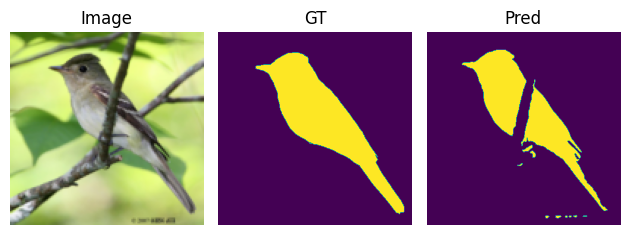

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [48:54<00:00,  2.93s/it]

[CUB]acc: 93.58 iou: 65.34 f_max: 81.07 f_beta: 81.06


In [6]:
result = evaluate_dataset("CUB", data_root, checkpoint)
print("[CUB]" + " ".join([f"{k}: {100*v:.2f}" for k, v in result.items()]))

Using cache found in /users/subha/.cache/torch/hub/facebookresearch_dino_main
Using cache found in /users/subha/.cache/torch/hub/facebookresearch_dino_main
  0%|                                                                                                                                                                              | 1/5019 [00:01<2:40:18,  1.92s/it]

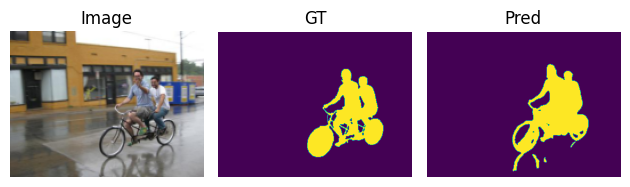

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5019/5019 [3:04:16<00:00,  2.20s/it]


[DUTS]acc: 91.54 iou: 49.10 f_max: 65.59 f_beta: 65.58


In [7]:
result = evaluate_dataset("DUTS", data_root, checkpoint)
print("[DUTS]" + " ".join([f"{k}: {100*v:.2f}" for k, v in result.items()]))

Using cache found in /users/subha/.cache/torch/hub/facebookresearch_dino_main
Using cache found in /users/subha/.cache/torch/hub/facebookresearch_dino_main
  0%|▏                                                                                                                                                                               | 1/1000 [00:01<29:32,  1.77s/it]

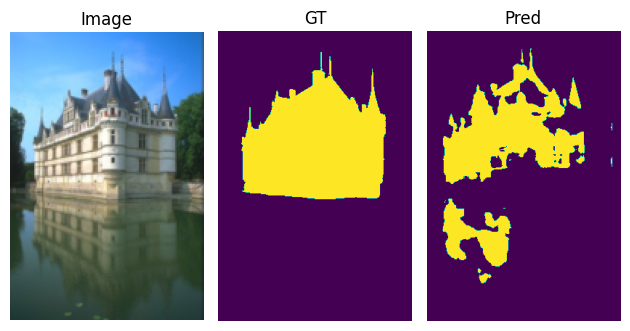

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [21:29<00:00,  1.29s/it]

[ECSSD]acc: 88.43 iou: 55.96 f_max: 74.88 f_beta: 74.20


In [8]:
result = evaluate_dataset("ECSSD", data_root, checkpoint)
print("[ECSSD]" + " ".join([f"{k}: {100*v:.2f}" for k, v in result.items()]))

Using cache found in /users/subha/.cache/torch/hub/facebookresearch_dino_main
Using cache found in /users/subha/.cache/torch/hub/facebookresearch_dino_main
  0%|                                                                                                                                                                              | 1/5168 [00:02<3:25:57,  2.39s/it]

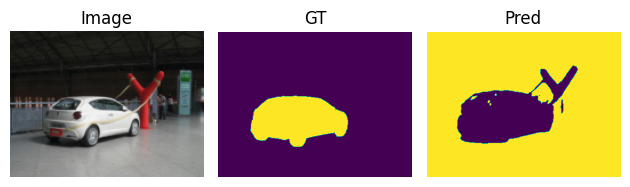

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5168/5168 [1:58:59<00:00,  1.38s/it]


[DUT_OMRON]acc: 89.38 iou: 41.25 f_max: 56.56 f_beta: 56.33


In [9]:
result = evaluate_dataset("DUT_OMRON", data_root, checkpoint)
print("[DUT_OMRON]" + " ".join([f"{k}: {100*v:.2f}" for k, v in result.items()]))